# Início: Preparação dos dados

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random as rd
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from scipy import stats

In [17]:
%matplotlib inline

# @grellert: removendo warnings chatos
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [18]:
import os
import pandas as pd
import numpy as np

path = os.path.join('..','dados','brutos','INMET','INMET_SE_RJ_A621.CSV')

# 1) tenta encodings comuns do INMET
for enc in ("latin1", "cp1252"):
    try:
        df = pd.read_csv(
            path,
            sep=";",
            encoding=enc,
            engine="python",
            skiprows=8,                 # pula REGIAO/UF/ESTACAO/... (ajuste se necessário)
            decimal=",",                # vírgula decimal brasileira
        )
        print(f"Lido com encoding={enc} | shape={df.shape}")
        break
    except UnicodeDecodeError:
        df = None

if df is None:
    raise UnicodeDecodeError("Não consegui ler com latin1/cp1252. Tente outro encoding ou inspecione o arquivo.")

# 2) limpa nomes de colunas (remove espaços extras)
df.columns = [c.strip() for c in df.columns]

# 3) cria datetime (Data + Hora UTC) se existir
# exemplos: "2025/01/01" + "0000 UTC"
if "Data" in df.columns and "Hora UTC" in df.columns:
    hora = df["Hora UTC"].astype(str).str.extract(r"(\d{4})")[0]
    df["datetime_utc"] = pd.to_datetime(df["Data"].astype(str) + " " + hora, format="%Y/%m/%d %H%M", errors="coerce")

df.head()


Lido com encoding=latin1 | shape=(8760, 20)


,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,datetime_utc
0,2025/01/01,0000 UTC,0.0,1010.4,1010.7,1009.9,0.0,24.4,20.9,25.5,...,21.4,19.9,82.0,71.0,80.0,126.0,1.7,0.2,NaN,2025-01-01 00:00:00
1,2025/01/01,0100 UTC,0.0,1010.9,1011.0,1010.4,0.0,23.6,21.7,24.4,...,21.9,20.8,90.0,81.0,89.0,31.0,1.9,0.0,NaN,2025-01-01 01:00:00
2,2025/01/01,0200 UTC,0.0,1010.4,1010.9,1010.4,0.0,24.3,21.6,24.4,...,22.0,21.1,89.0,83.0,85.0,175.0,1.0,0.0,NaN,2025-01-01 02:00:00
3,2025/01/01,0300 UTC,0.0,1010.1,1010.5,1010.0,0.0,23.8,21.9,24.4,...,21.9,21.0,90.0,81.0,89.0,16.0,0.7,0.1,NaN,2025-01-01 03:00:00
4,2025/01/01,0400 UTC,0.0,1009.7,1010.2,1009.6,0.0,24.6,20.6,24.6,...,22.1,20.6,90.0,78.0,78.0,206.0,1.6,0.4,NaN,2025-01-01 04:00:00


In [19]:
df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,datetime_utc
0,2025/01/01,0000 UTC,0.0,1010.4,1010.7,1009.9,0.0,24.4,20.9,25.5,...,21.4,19.9,82.0,71.0,80.0,126.0,1.7,0.2,NaN,2025-01-01 00:00:00
1,2025/01/01,0100 UTC,0.0,1010.9,1011.0,1010.4,0.0,23.6,21.7,24.4,...,21.9,20.8,90.0,81.0,89.0,31.0,1.9,0.0,NaN,2025-01-01 01:00:00
2,2025/01/01,0200 UTC,0.0,1010.4,1010.9,1010.4,0.0,24.3,21.6,24.4,...,22.0,21.1,89.0,83.0,85.0,175.0,1.0,0.0,NaN,2025-01-01 02:00:00
3,2025/01/01,0300 UTC,0.0,1010.1,1010.5,1010.0,0.0,23.8,21.9,24.4,...,21.9,21.0,90.0,81.0,89.0,16.0,0.7,0.1,NaN,2025-01-01 03:00:00
4,2025/01/01,0400 UTC,0.0,1009.7,1010.2,1009.6,0.0,24.6,20.6,24.6,...,22.1,20.6,90.0,78.0,78.0,206.0,1.6,0.4,NaN,2025-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2025/12/31,1900 UTC,0.0,1005.6,1006.3,1005.6,2233.0,34.1,22.5,36.1,...,23.5,19.2,55.0,39.0,51.0,211.0,5.9,2.6,NaN,2025-12-31 19:00:00
8756,2025/12/31,2000 UTC,0.0,1005.1,1005.6,1005.0,1203.1,32.0,23.3,34.5,...,23.7,21.9,61.0,50.0,60.0,244.0,5.5,2.3,NaN,2025-12-31 20:00:00
8757,2025/12/31,2100 UTC,0.0,1006.1,1006.1,1005.1,575.1,30.5,23.5,32.4,...,24.4,23.0,69.0,59.0,66.0,253.0,5.2,1.8,NaN,2025-12-31 21:00:00
8758,2025/12/31,2200 UTC,0.0,1007.3,1007.3,1006.1,51.8,28.7,23.7,30.5,...,24.5,23.4,77.0,66.0,75.0,262.0,6.4,1.3,NaN,2025-12-31 22:00:00


In [20]:
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

Data: object
Hora UTC: object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm): float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB): float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB): float64
RADIACAO GLOBAL (Kj/m²): float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C): float64
TEMPERATURA DO PONTO DE ORVALHO (°C): float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C): float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C): float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C): float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C): float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%): float64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%): float64
UMIDADE RELATIVA DO AR, HORARIA (%): float64
VENTO, DIREÇÃO HORARIA (gr) (° (gr)): float64
VENTO, RAJADA MAXIMA (m/s): float64
VENTO, VELOCIDADE HORARIA (m/s): float64
Unnamed: 19: float64
datetime_utc: datetime64[ns]


In [21]:
df = df.dropna(axis=1, how='all')


In [22]:
np.where(pd.isnull(df))

(array([ 433, 1057, 1297, 1561, 1825, 2065, 2593, 2833, 2846, 2846, 2846,
        2846, 2846, 2846, 2846, 2846, 2846, 4956, 4956, 4956, 4956, 4956,
        4956, 4956, 4956, 4956, 4956, 4956, 4956, 4956, 4956, 4956, 4956,
        4956, 5874, 5874, 5874, 5874, 5874, 5874, 5874, 5874, 5874, 5874,
        5874, 5874, 5874, 5874, 5874, 5874, 5874, 5875, 5875, 5875, 5875,
        5875, 5875, 5875, 5875, 5875, 5875, 5875, 5875, 5875, 5875, 5875,
        5875, 5875, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876,
        5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5877, 5877, 5877,
        5877, 5877, 5877, 5877, 5877, 5877, 5877, 5877, 5877, 5877, 5877,
        5877, 5877, 5877, 6884, 6884, 6884, 6884, 6884, 6884, 6884, 6884,
        6884, 6884, 6884, 6884, 6884, 6884, 6884, 6884, 6884, 7072, 7072,
        7072, 7072, 7072, 7072, 7072, 7072, 7072, 7072, 7072, 7072, 7072,
        7072, 7072, 7072, 7072, 7073, 7073, 7073, 7073, 7073, 7073, 7073,
        7073, 7073, 7073, 7073, 7073, 

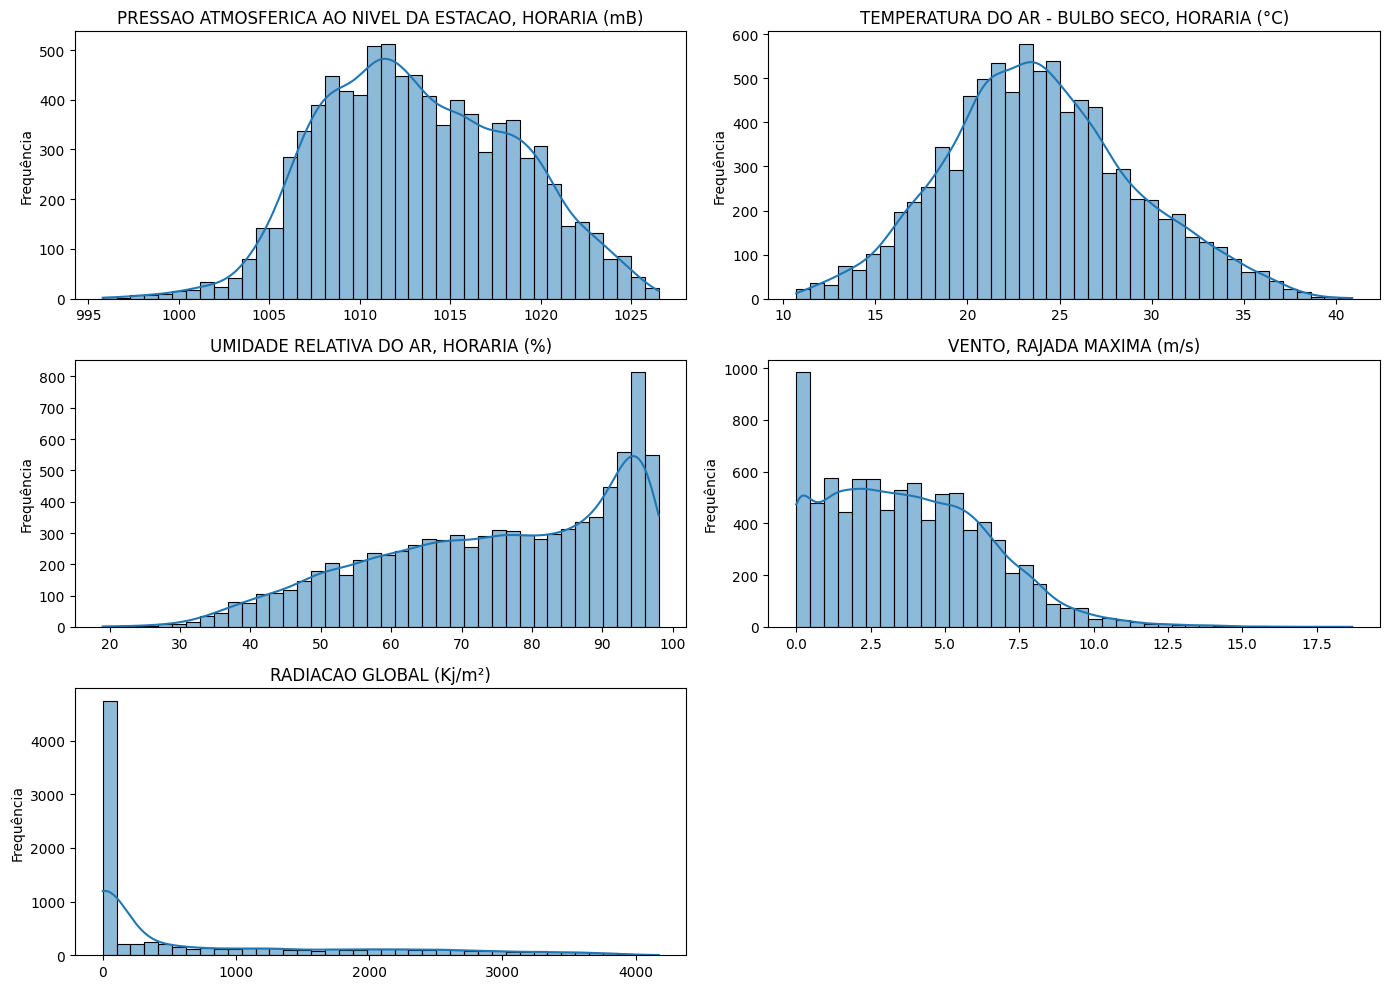

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_cols = [
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, RAJADA MAXIMA (m/s)',
    'RADIACAO GLOBAL (Kj/m²)'  # se decidir manter
]

plt.figure(figsize=(14, 10))

for i, col in enumerate(selected_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()



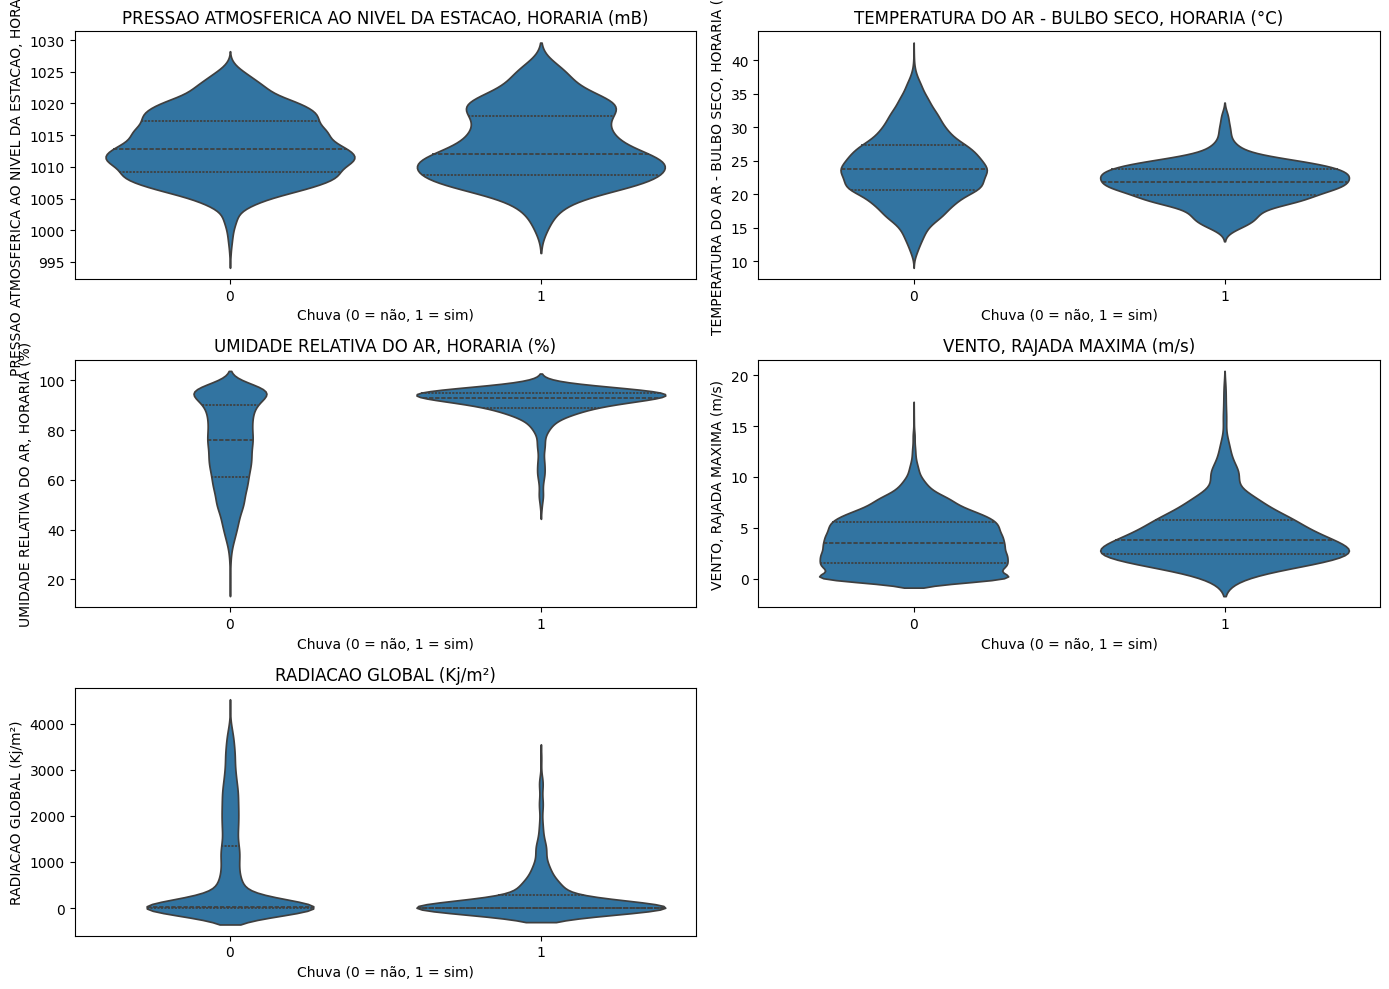

In [27]:
df['chuva'] = np.where(
    df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0,
    1,
    0
)

plt.figure(figsize=(14, 10))

for i, col in enumerate(selected_cols, 1):
    plt.subplot(3, 2, i)
    sns.violinplot(
        data=df,
        x='chuva',
        y=col,
        inner='quartile'
    )
    plt.title(col)
    plt.xlabel("Chuva (0 = não, 1 = sim)")

plt.tight_layout()
plt.show()


In [11]:
df.describe()

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime_utc
count,8746.000000,8746.000000,8745.000000,8745.000000,8738.000000,8746.000000,8746.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8746.000000,8746.000000,8745.000000,8746.000000,8760
mean,0.095701,1013.243117,1013.493196,1012.991366,727.812989,23.945895,18.717802,24.615883,23.317256,19.241589,18.228908,78.199428,72.052030,75.181340,154.597988,3.764288,1.135147,2025-07-02 11:30:00
min,0.000000,995.800000,996.100000,995.800000,0.000000,10.700000,8.300000,10.900000,10.000000,9.800000,7.200000,22.000000,17.000000,19.000000,1.000000,0.000000,0.000000,2025-01-01 00:00:00
25%,0.000000,1009.200000,1009.500000,1009.000000,0.000000,20.500000,16.600000,21.000000,20.000000,17.100000,16.100000,66.000000,58.000000,62.000000,42.000000,1.600000,0.000000,2025-04-02 05:45:00
50%,0.000000,1012.800000,1013.100000,1012.600000,23.550000,23.700000,19.000000,24.200000,23.100000,19.400000,18.500000,82.000000,74.000000,78.000000,149.000000,3.500000,0.900000,2025-07-02 11:30:00
75%,0.000000,1017.300000,1017.500000,1017.000000,1270.300000,27.100000,21.200000,27.900000,26.400000,21.800000,20.800000,93.000000,88.000000,91.000000,236.000000,5.600000,1.900000,2025-10-01 17:15:00
max,31.600000,1026.500000,1026.500000,1026.400000,4173.500000,40.900000,25.700000,41.200000,40.300000,26.100000,25.000000,99.000000,98.000000,98.000000,360.000000,18.700000,8.000000,2025-12-31 23:00:00
std,0.918851,5.274613,5.247904,5.294614,1061.845585,5.125640,3.097225,5.257031,4.991936,3.060835,3.149535,16.482129,18.039772,17.422318,112.259219,2.687451,1.148389,NaN


In [12]:
TH_CATEGORICO = 5
categoricos = [] 
string = []
quantitativos = []
nao_numericos = []

for col in df:
    print(col, df[col].unique())
    unicos = df[col].unique()
    ## dividindo colunas entre valores categoricos e quantitativos:
    if unicos.shape[0] < TH_CATEGORICO:
        categoricos.append(col)
    else: 
        quantitativos.append(col)
print(f'colunas categoricas: {len(categoricos)}, quantitativas: {len(quantitativos)}')

Data ['2025/01/01' '2025/01/02' '2025/01/03' '2025/01/04' '2025/01/05'
 '2025/01/06' '2025/01/07' '2025/01/08' '2025/01/09' '2025/01/10'
 '2025/01/11' '2025/01/12' '2025/01/13' '2025/01/14' '2025/01/15'
 '2025/01/16' '2025/01/17' '2025/01/18' '2025/01/19' '2025/01/20'
 '2025/01/21' '2025/01/22' '2025/01/23' '2025/01/24' '2025/01/25'
 '2025/01/26' '2025/01/27' '2025/01/28' '2025/01/29' '2025/01/30'
 '2025/01/31' '2025/02/01' '2025/02/02' '2025/02/03' '2025/02/04'
 '2025/02/05' '2025/02/06' '2025/02/07' '2025/02/08' '2025/02/09'
 '2025/02/10' '2025/02/11' '2025/02/12' '2025/02/13' '2025/02/14'
 '2025/02/15' '2025/02/16' '2025/02/17' '2025/02/18' '2025/02/19'
 '2025/02/20' '2025/02/21' '2025/02/22' '2025/02/23' '2025/02/24'
 '2025/02/25' '2025/02/26' '2025/02/27' '2025/02/28' '2025/03/01'
 '2025/03/02' '2025/03/03' '2025/03/04' '2025/03/05' '2025/03/06'
 '2025/03/07' '2025/03/08' '2025/03/09' '2025/03/10' '2025/03/11'
 '2025/03/12' '2025/03/13' '2025/03/14' '2025/03/15' '2025/03/16'
 '202

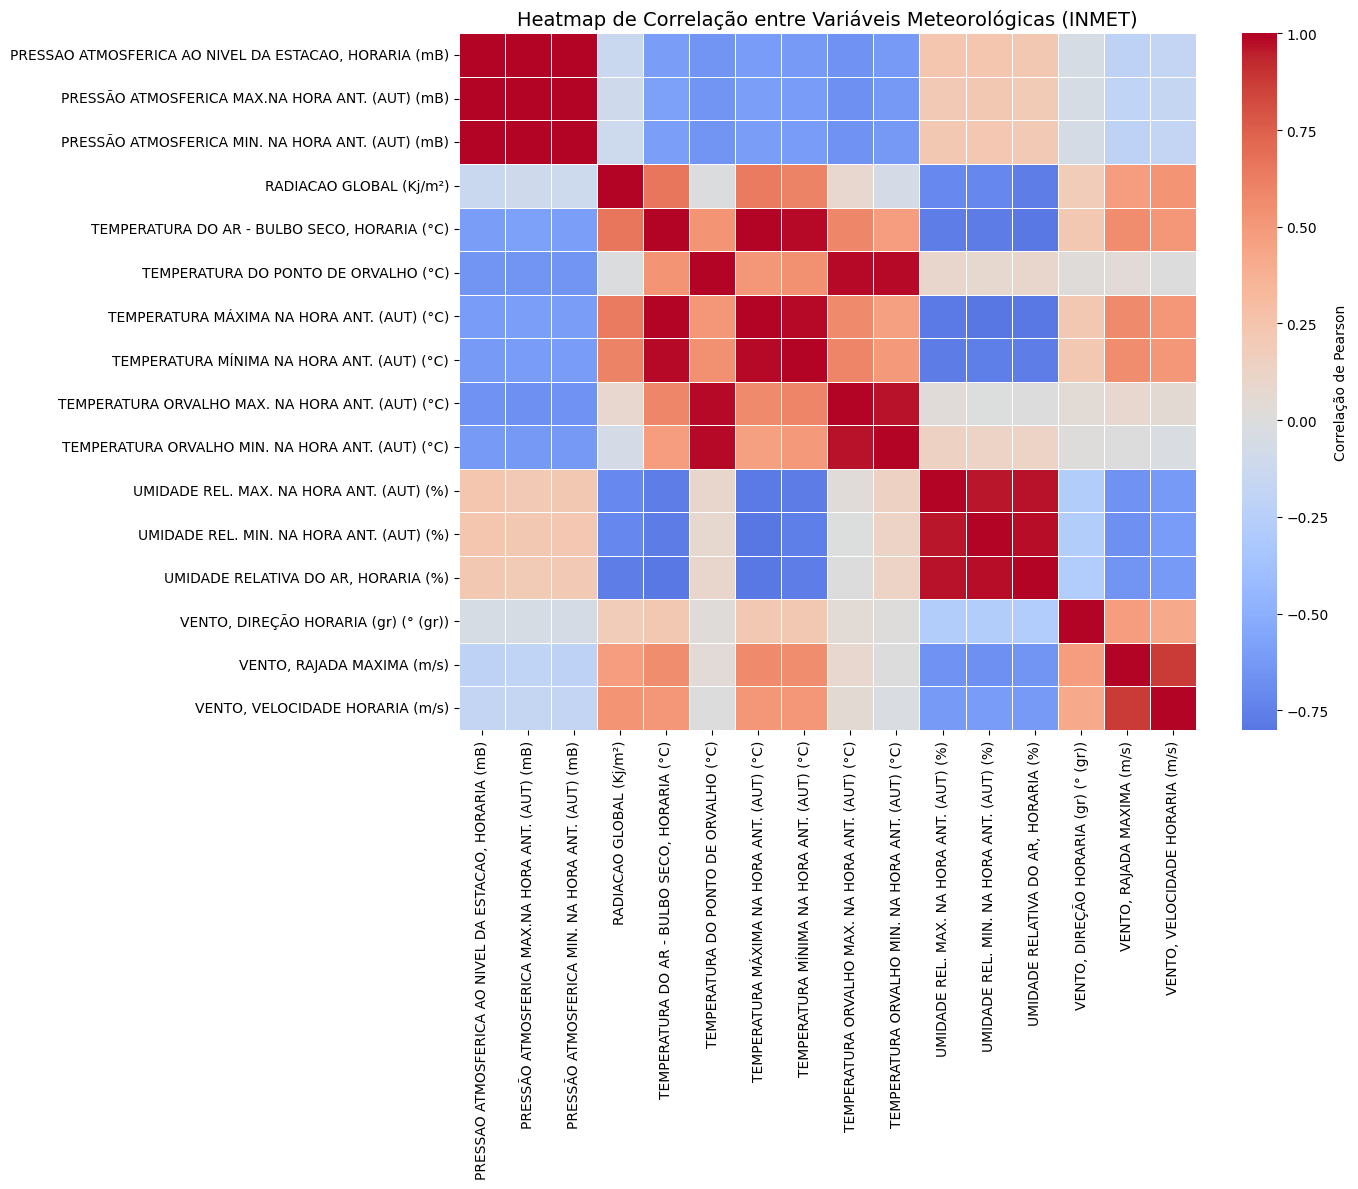

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1) Criação do desfecho (CLASSIFICAÇÃO)
# =========================
# 0 = não choveu | 1 = choveu
df['chuva'] = np.where(
    df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0,
    1,
    0
)

# =========================
# 2) Seleção das variáveis numéricas (exclui o alvo)
# =========================
num_cols = [
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (Kj/m²)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',
    'VENTO, RAJADA MAXIMA (m/s)',
    'VENTO, VELOCIDADE HORARIA (m/s)'
]

df_num = df[num_cols].copy()

# =========================
# 3) Matriz de correlação
# =========================
corr = df_num.corr(method='pearson')

# =========================
# 4) Heatmap
# =========================
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Correlação de Pearson'}
)

plt.title('Heatmap de Correlação entre Variáveis Meteorológicas (INMET)', fontsize=14)
plt.tight_layout()
plt.show()


# Fase I - Estatística

## Gerador de Dados Faltantes - MAR, MNAR e MCAR


Iniciando coleta de distribuições...
Total de cenários: 480
--------------------------------------------------

 Atributo atual: PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)
   % faltante: 5%
      Progresso: 10/480 (2.1%) | Tempo decorrido: 0.7 min | ETA: 31.8 min
      Progresso: 20/480 (4.2%) | Tempo decorrido: 1.4 min | ETA: 32.3 min
      Progresso: 30/480 (6.2%) | Tempo decorrido: 2.2 min | ETA: 32.5 min
   % faltante: 10%
      Progresso: 40/480 (8.3%) | Tempo decorrido: 3.3 min | ETA: 35.9 min
      Progresso: 50/480 (10.4%) | Tempo decorrido: 4.1 min | ETA: 35.1 min
      Progresso: 60/480 (12.5%) | Tempo decorrido: 4.9 min | ETA: 34.6 min
   % faltante: 15%
      Progresso: 70/480 (14.6%) | Tempo decorrido: 5.9 min | ETA: 34.5 min
      Progresso: 80/480 (16.7%) | Tempo decorrido: 6.8 min | ETA: 33.8 min
      Progresso: 90/480 (18.8%) | Tempo decorrido: 7.7 min | ETA: 33.4 min
   % faltante: 20%
      Progresso: 100/480 (20.8%) | Tempo decorrido: 9.8 min | ETA: 37.

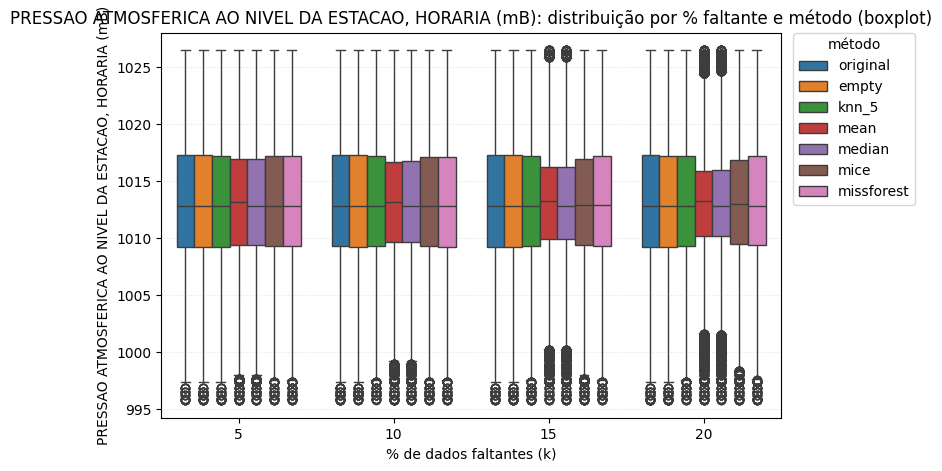

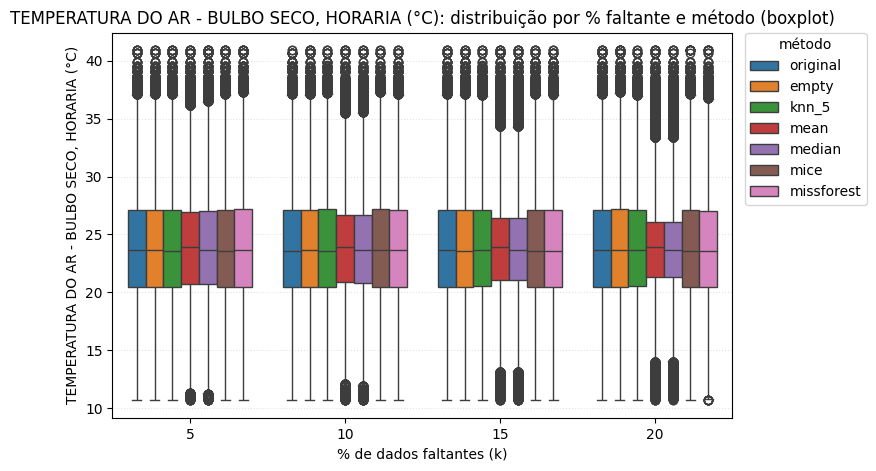

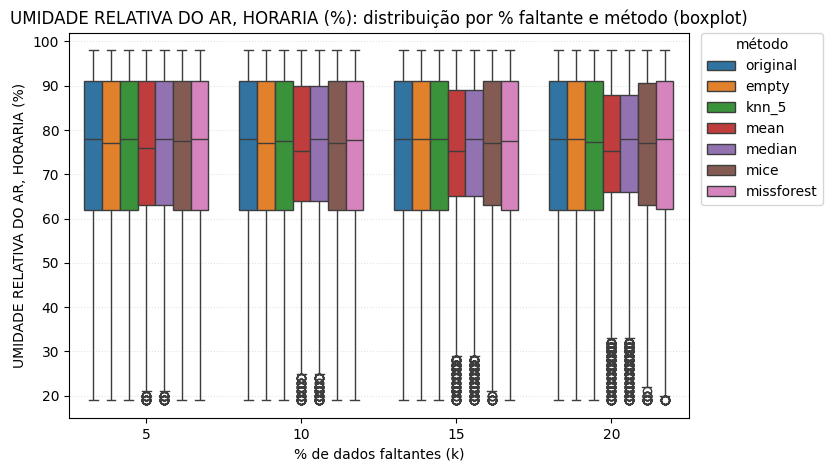

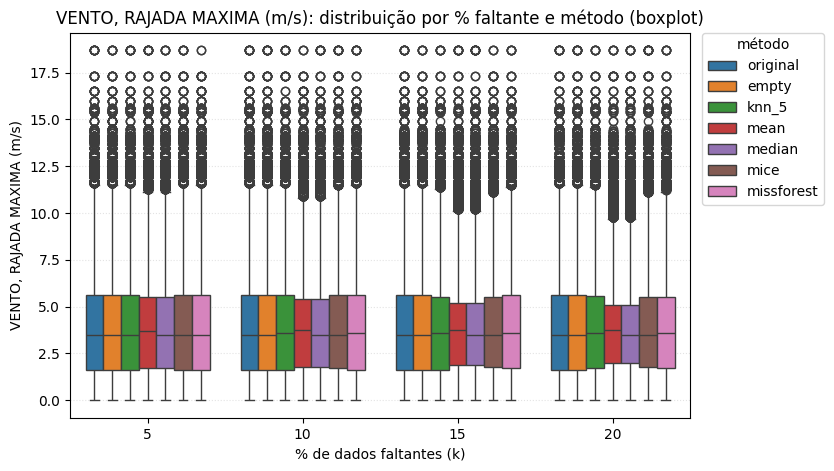

In [15]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


# ---------------------------------------------------------
# Helpers: aplicar uma imputação sobre um X_nan JÁ mascarado
# ---------------------------------------------------------
def _apply_imputation(X_nan: pd.DataFrame, method: str, seed: int | None = None) -> pd.DataFrame:
    """Aplica imputação no DataFrame X_nan (com NaNs já aplicados).
       Retorna um DataFrame imputado (todas as colunas numéricas)."""
    if method == "mean":
        Xi = X_nan.copy()
        for c in Xi.columns:
            Xi[c] = Xi[c].fillna(Xi[c].mean())
        return Xi

    if method == "median":
        Xi = X_nan.copy()
        for c in Xi.columns:
            Xi[c] = Xi[c].fillna(Xi[c].median())
        return Xi

    if method.startswith("knn_"):
        try:
            n = int(method.split("_", 1)[1])
        except Exception:
            raise ValueError("Use método como 'knn_5', 'knn_7', etc.")
        imp = KNNImputer(n_neighbors=n)
        return pd.DataFrame(imp.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)

    if method == "mice":
        col_mins = X_nan.quantile(0.01, numeric_only=True).reindex(X_nan.columns).to_numpy()
        col_maxs = X_nan.quantile(0.99, numeric_only=True).reindex(X_nan.columns).to_numpy()
        Xnum = X_nan.to_numpy(dtype=float)
        col_mins = np.where(np.isfinite(col_mins), col_mins, np.nanmin(Xnum, axis=0))
        col_maxs = np.where(np.isfinite(col_maxs), col_maxs, np.nanmax(Xnum, axis=0))

        imp = IterativeImputer(
            max_iter=20,
            imputation_order="ascending",
            initial_strategy="median",
            skip_complete=True,
            sample_posterior=False,
            min_value=col_mins,
            max_value=col_maxs,
            random_state=seed,
        )
        return pd.DataFrame(imp.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)
    
    if method == "missforest":
        est = RandomForestRegressor(
            n_estimators=200,
            random_state=seed,
            n_jobs=-1
        )
        imp = IterativeImputer(
            estimator=est,
            max_iter=10,
            initial_strategy="median",
            skip_complete=True,
            random_state=seed
        )
        return pd.DataFrame(imp.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)

    if method == "empty":
        return X_nan.copy()

    raise ValueError(f"Método inválido: {method}")

# ---------------------------------------------------------
# Coletar "dados brutos" (valores) para plotar as distribuições
# ---------------------------------------------------------
import time

def collect_raw_distributions(
    X: pd.DataFrame,
    y: pd.Series,
    columns: list[str],
    methods: list[str],
    ks=(5, 10, 15, 20),
    reps=10,
    missing_mech="MCAR",
    seed_base=2025,
    sample_per_cell: int | None = 2000,
    pick_missing_indices=None,
    verbose=True
):
    assert pick_missing_indices is not None, "Passe sua função pick_missing_indices."
    rows = []

    total_steps = len(columns) * len(ks) * reps
    step = 0
    t0 = time.time()

    if verbose:
        print(f"\nIniciando coleta de distribuições...")
        print(f"Total de cenários: {total_steps}")
        print("-" * 50)

    for col in columns:
        if verbose:
            print(f"\n Atributo atual: {col}")

        v_orig_full = X[col].to_numpy()

        for k in ks:
            if verbose:
                print(f"   % faltante: {k}%")

            for r in range(reps):
                step += 1
                seed = seed_base + 1000 * k + r
                rng = np.random.default_rng(seed)

                X_nan = X.copy(deep=True)
                to_nan = pick_missing_indices(missing_mech, X_nan, y, col, k, seed=seed)
                if len(to_nan) > 0:
                    X_nan.loc[to_nan, col] = np.nan

                # ORIGINAL
                v_orig = v_orig_full
                if sample_per_cell is not None and len(v_orig) > sample_per_cell:
                    v_orig = rng.choice(v_orig, size=sample_per_cell, replace=False)
                rows.extend((col, k, "original", r, float(v)) for v in v_orig if np.isfinite(v))

                # MÉTODOS
                for method in methods:
                    Xi = _apply_imputation(X_nan, method, seed=seed)
                    if method == "empty":
                        v_vals = Xi[col].dropna().to_numpy()
                    else:
                        v_vals = Xi[col].to_numpy()

                    if sample_per_cell is not None and len(v_vals) > sample_per_cell:
                        v_vals = rng.choice(v_vals, size=sample_per_cell, replace=False)

                    rows.extend((col, k, method, r, float(v)) for v in v_vals if np.isfinite(v))

                # -------- PROGRESSO --------
                if verbose and (step % 10 == 0 or step == total_steps):
                    elapsed = time.time() - t0
                    progress = step / total_steps
                    eta = (elapsed / step) * (total_steps - step)

                    print(
                        f"      Progresso: {step}/{total_steps} "
                        f"({progress*100:.1f}%) | "
                        f"Tempo decorrido: {elapsed/60:.1f} min | "
                        f"ETA: {eta/60:.1f} min",
                        flush=True
                    )

    if verbose:
        total_time = time.time() - t0
        print("\n Finalizado!")
        print(f"Tempo total: {total_time/60:.2f} minutos")

    return pd.DataFrame(rows, columns=["attribute", "pct_imputed", "method", "rep", "value"])

# ---------------------------------------------------------
# Plots: BOX – x = % faltante, hue = método
# ---------------------------------------------------------
def plot_box_all_methods_one_axis(
    df_long: pd.DataFrame,
    attribute: str,
    order_pct: list[int] = (5, 10, 15, 20),
    showfliers: bool = False,
    height: float = 5.0,
    aspect: float = 1.6,
    legend_out: bool = True,
):
    dfp = df_long[df_long["attribute"] == attribute].copy()
    dfp["pct_imputed"] = pd.Categorical(dfp["pct_imputed"], categories=order_pct, ordered=True)
    base = ["original"]
    outros = sorted([m for m in dfp["method"].unique() if m not in base])
    order_methods = base + outros
    dfp["method"] = pd.Categorical(dfp["method"], categories=order_methods, ordered=True)

    plt.figure(figsize=(height * aspect, height))
    ax = sns.boxplot(
        data=dfp, x="pct_imputed", y="value",
        hue="method", order=order_pct, hue_order=order_methods,
        showfliers=showfliers
    )
    ax.set_xlabel("% de dados faltantes (k)")
    ax.set_ylabel(attribute)
    ax.set_title(f"{attribute}: distribuição por % faltante e método (boxplot)")
    if legend_out:
        ax.legend(title="método", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    else:
        ax.legend(title="método")
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    return ax

# ---------------------------------------------------------
# USO com INMET: desfecho chuva + colunas selecionadas
# ---------------------------------------------------------
# 0) garanta que df já existe e que as colunas abaixo estão com esses nomes

# 1) Desfecho (chuva vs não chuva)
target_col = 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'
df['chuva'] = np.where(df[target_col] > 0, 1, 0).astype('int64')

y = df['chuva'].copy()

# 2) Colunas a serem analisadas (as 4 que você escolheu)
selected_cols = [
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, RAJADA MAXIMA (m/s)'
]

# 3) X só com essas colunas (numeric)
X = df[selected_cols].copy()

# (Opcional) remover linhas sem alvo (precipitação NaN)
mask_valid_y = df[target_col].notna()
X = X.loc[mask_valid_y]
y = y.loc[mask_valid_y]

# 4) Função de mascaramento (MCAR simples)
def pick_missing_indices(missing_mech, X, y, col, k, seed=None):
    rng = np.random.default_rng(seed)
    candidates = X.index[X[col].notna()].to_numpy()  # só onde há dado observado
    m = int(round(len(candidates) * (k / 100.0)))
    m = min(m, len(candidates))
    return rng.choice(candidates, size=m, replace=False) if m > 0 else []

# 5) Rodar coleta e plotar
methods = ["empty", "mean", "median", "knn_5", "mice", "missforest"]
ks = (5, 10, 15, 20)
reps = 30

df_long = collect_raw_distributions(
    X, y,
    columns=selected_cols,
    methods=methods,
    ks=ks,
    reps=reps,
    missing_mech="MCAR",
    seed_base=2025,
    sample_per_cell=2000,
    pick_missing_indices=pick_missing_indices,
    verbose=True
)

for attr in selected_cols:
    ax = plot_box_all_methods_one_axis(df_long, attr, order_pct=list(ks), showfliers=True)
    plt.show()
